# Import Data
First, let's use the pandas library to import the data and store it. It is quite obvious that the first sample is a fluke, and was thus ignored.

In [1]:
## Import Raw Data, convert to_datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.fft as fft
import scipy.signal as sig

from diptest import diptest
from sklearn.cluster import KMeans
from seaborn import kdeplot

import mylib as my

## CONSTANTS
from myconstants import *
HEADER = 'Current 1 (amps)'

## IMPORT
dl1 = my.import_csv("../data/DL1March_May_24.csv")
dl3 = my.import_csv("../data/DL3March_May_24.csv")

# Statistical Analysis

## Determine Distribution and Multimodality
It is unkown what type of distribution this power consumption obeys. My hypothesis is that, as a natural random event, it follows a normal distribution. Let's explore this further. Here, we will analyse current, as it has a higher accuracy: all measures are taken with a precision of up to 0.1, and as most are within a range of 10, this gives them 2 digits of precision, while current current has 3. 

As the first sample has a significantly low current value, it is considered an outlier and removed for clarity for this part of the study.

We can easily observe 3 distinct peaks on the histogram of the full data: this makes me think the distribution is in reality multimodal. Therefore, in this section, I will use the same function in order to identify whether or not this is true by separating the dataset into various chunks of my choosing, depending on variables we have previously studied, such as, but not limited to, days of the week, and time of day. To prove this multimodality, we can use Hartigan's Dip Test, where a result of a low p-value indicates evidence against unimodality.

Dip: 0.023048568072264682; p = 0.0	<- An extremely low p (approximated as 0) indicates multimodality
Cluster centers (modes): [22.60802621 25.98502865 30.00702794]
Modes: [22.66206296 25.95402099 28.34817228]


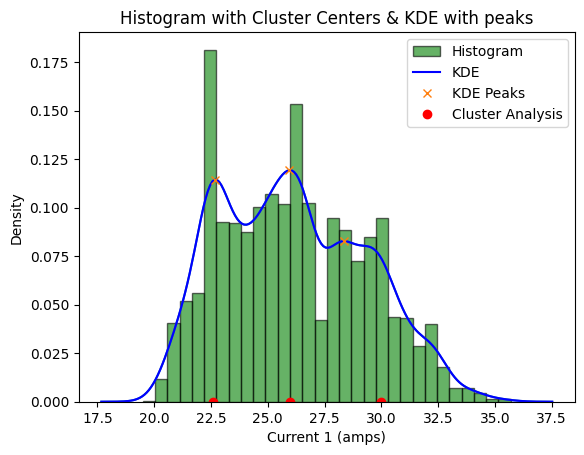

In [2]:
## DETERMINE MULTIMODALITY AND PLOT
dip, p_value = diptest(dl1[HEADER])
print(f'Dip: {dip}; p = {p_value}\t<- An extremely low p '+('(approximated as 0) ' if p_value == 0 else '') + 'indicates multimodality')

##
reshaped = np.array(dl1[HEADER]).reshape(-1, 1)
# Apply k-means clustering with k=3 (assuming three modes for simplicity)
kmeans = KMeans(n_clusters=3)
kmeans.fit(reshaped)

# Cluster centers represent modes
print("Cluster centers (modes):", cluster_centers := np.sort(kmeans.cluster_centers_.flatten()))

x_kde, y_kde = kdeplot(dl1[HEADER]).lines[0].get_data()
peaks, _ = sig.find_peaks(y_kde)
print("Modes:", MODES:=np.sort(x_kde[peaks]))

# Plot the results
plt.hist(dl1[HEADER], bins=30, alpha=0.6, color='g', edgecolor='k', label='Histogram', density=True)
plt.legend(loc='upper left')
plt.title('Histogram with Cluster Centers & KDE with peaks')
plt.plot(x_kde, y_kde, '-b', label='KDE')
plt.plot(x_kde[peaks], y_kde[peaks], "x", label='KDE Peaks')
plt.plot(cluster_centers, np.zeros(len(cluster_centers)), 'o', color='r', label='Cluster Analysis')
plt.legend(loc='upper right')
plt.show()

We can conclude that there are at the very least two noticeable modes: one near **22.7A** and the other near **26.2A**. There is some ambiguity as to the location of the other mode, but this is already a lot to work from. From now on, we will try to manually isolate the distributions in order to identify the modes.
We will also mark the known modes in every subsequent statistical analysis.

### Full Dataset Analysis

------------------------------CURRENT 1 (AMPS)-----------------------------
DATASET STATISTICS:
Mean: 26.150026329647183
Standard Deviation: 3.1635477696953713
Minimum Value: 19.5
25th Percentile: 23.4
Median: 26.0
75th Percentile: 28.5
Maximum: 35.7
Skewness: 0.295968242120477
Kurtosis: -0.7457128257012542

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9751, p=3.1660290621743946e-25
DAgostino and Pearsons Test: stat=300.1416, p=6.684774015680118e-66
Kolmogorov-Smirnov Test: stat=0.06259205114291694, p=2.2286907040033107e-13

FITTING TO OTHER DISTRIBUTIONS: 

Best fitting distribution: rayleigh
Best p value: 3.471757141676038e-08
Parameters for the best fit: (19.49329697729327, 5.21152953371823)


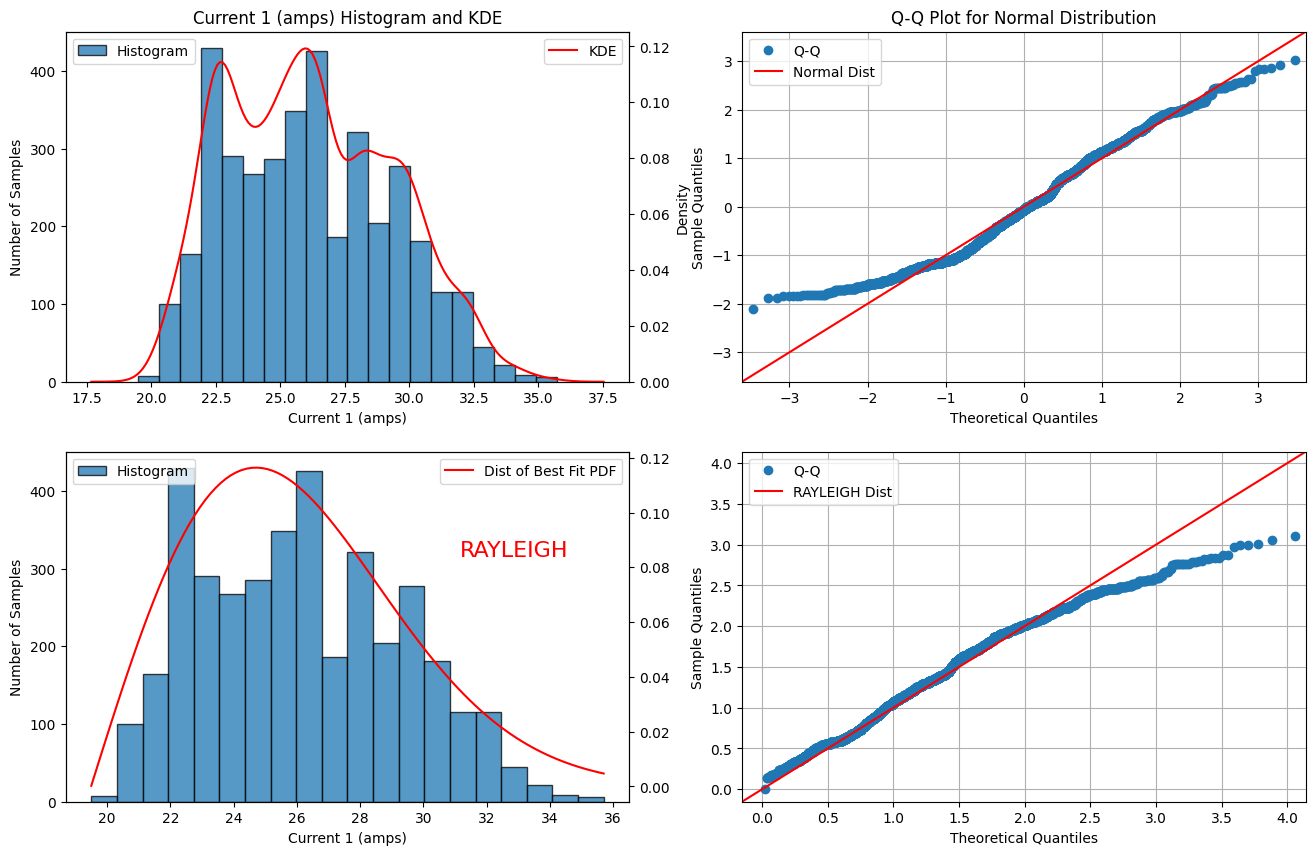

In [3]:
INCLUDE_CDF = False
INCLUDE_AUTOCORR = False
my.statistical_analysis(dl1[HEADER], bins=20, header=HEADER, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

### On Bank Holidays
In order to streamline the testing process, I had an idea to make a testing suite that takes in a Series or DataFrame and obtains all the required information we need to make a statement about the subsets of the dataset we will be analysing.

-------------------CURRENT 1 (AMPS) DURING BANK HOLIDAYS-------------------
DATASET STATISTICS:
Mean: 27.718287037037037
Standard Deviation: 2.62126521455139
Minimum Value: 21.1
25th Percentile: 26.1
Median: 28.3
75th Percentile: 28.9
Maximum: 34.0
Skewness: -0.1385749516907255
Kurtosis: 0.24925905865706044

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9572, p=7.142027955141754e-10
DAgostino and Pearsons Test: stat=2.7130, p=0.2575597189638062
Kolmogorov-Smirnov Test: stat=0.14347154041208854, p=3.1897259880685206e-08

FITTING TO OTHER DISTRIBUTIONS: 


c:\Users\ogahe\OneDrive\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis\Lib\site-packages\scipy\stats\_continuous_distns.py:2137: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +



Best fitting distribution: dweibull
Best p value: 5.441713807115236e-07
Parameters for the best fit: (0.9480083919588569, 28.299999999999997, 1.8997600759939832)


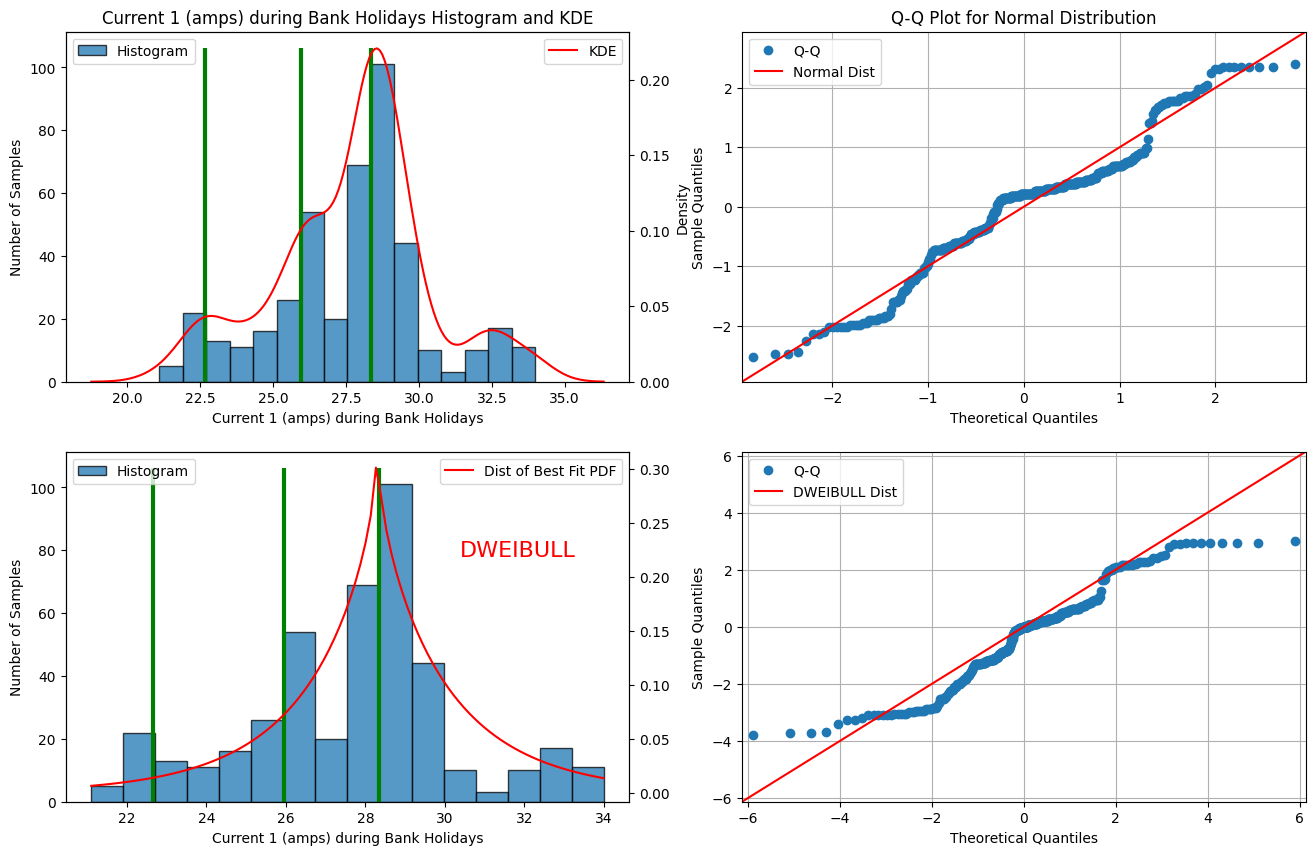

In [4]:
dl1_bank_holidays = pd.Series([val for i, val in enumerate(dl1[HEADER]) if dl1.index[i].normalize() in bank_holidays])
my.statistical_analysis(dl1_bank_holidays, bins=16, header=HEADER+' during Bank Holidays', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### Non-Bank Holidays

-----------------CURRENT 1 (AMPS) DURING NON BANK HOLIDAYS-----------------
DATASET STATISTICS:
Mean: 27.718287037037037
Standard Deviation: 2.62126521455139
Minimum Value: 21.1
25th Percentile: 26.1
Median: 28.3
75th Percentile: 28.9
Maximum: 34.0
Skewness: -0.1385749516907255
Kurtosis: 0.24925905865706044

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9572, p=7.142027955141754e-10
DAgostino and Pearsons Test: stat=2.7130, p=0.2575597189638062
Kolmogorov-Smirnov Test: stat=0.14347154041208854, p=3.1897259880685206e-08

FITTING TO OTHER DISTRIBUTIONS: 


c:\Users\ogahe\OneDrive\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis\Lib\site-packages\scipy\stats\_continuous_distns.py:2137: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +



Best fitting distribution: dweibull
Best p value: 5.441713807115236e-07
Parameters for the best fit: (0.9480083919588569, 28.299999999999997, 1.8997600759939832)


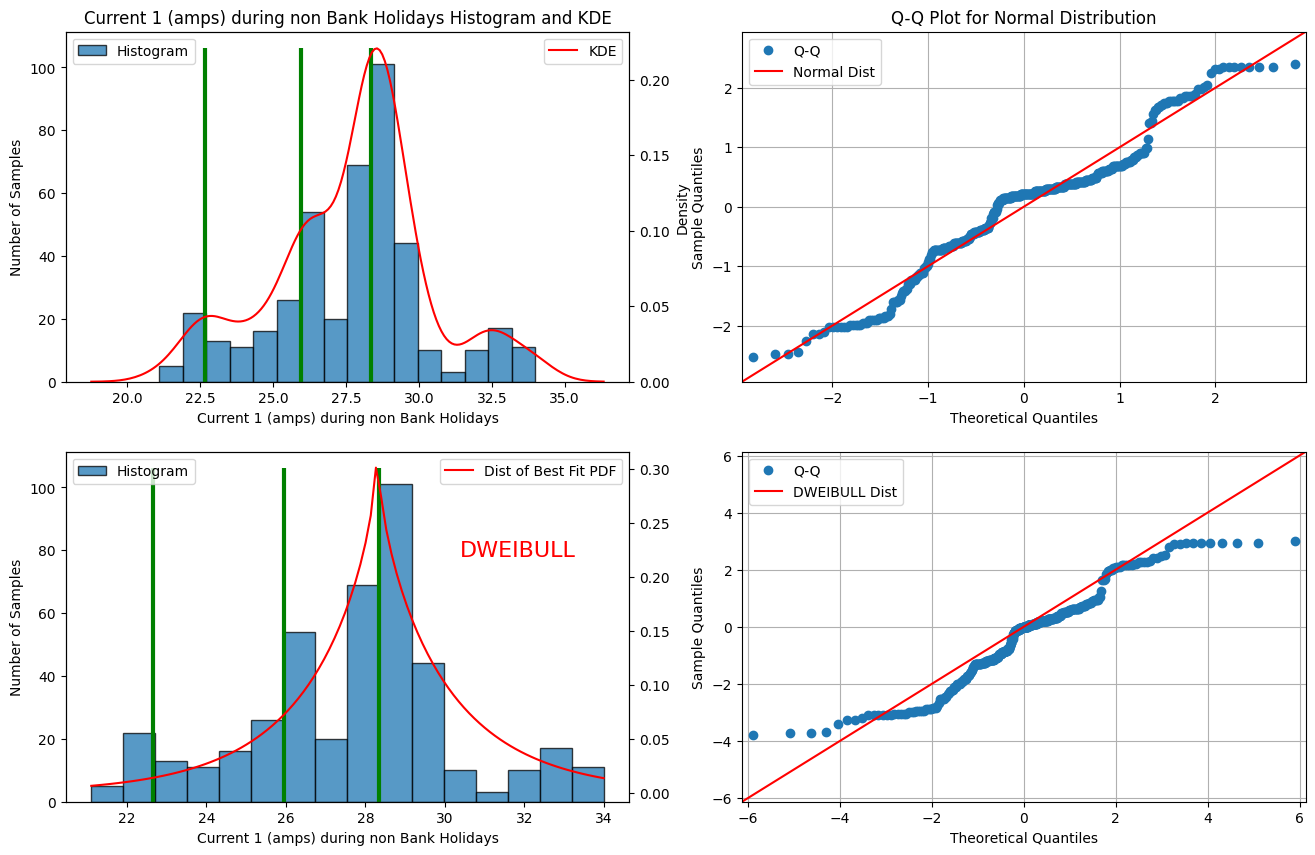

In [5]:
dl1_bank_holidays_not = pd.Series([val for i, val in enumerate(dl1[HEADER]) if dl1.index[i].normalize() not in bank_holidays])
my.statistical_analysis(dl1_bank_holidays, bins=16, header=HEADER+' during non Bank Holidays', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### During Term Time

In [6]:
dl1_term_times = dl1[HEADER].groupby(lambda x: x.normalize() in term_time).apply(pd.Series)

---------------------CURRENT 1 (AMPS) DURING TERM TIME---------------------
DATASET STATISTICS:
Mean: 25.954579792256848
Standard Deviation: 3.2009759028904483
Minimum Value: 19.5
25th Percentile: 23.1
Median: 25.7
75th Percentile: 28.1
Maximum: 35.7
Skewness: 0.42349071182670917
Kurtosis: -0.7206420427247049

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9609, p=1.8598477272383036e-23
DAgostino and Pearsons Test: stat=179.8196, p=8.9673605146969e-40
Kolmogorov-Smirnov Test: stat=0.08495790053390628, p=9.504565647170984e-14

FITTING TO OTHER DISTRIBUTIONS: 

Best fitting distribution: rayleigh
Best p value: 0.0003737087619788025
Parameters for the best fit: (19.487953829841302, 5.102131812716724)


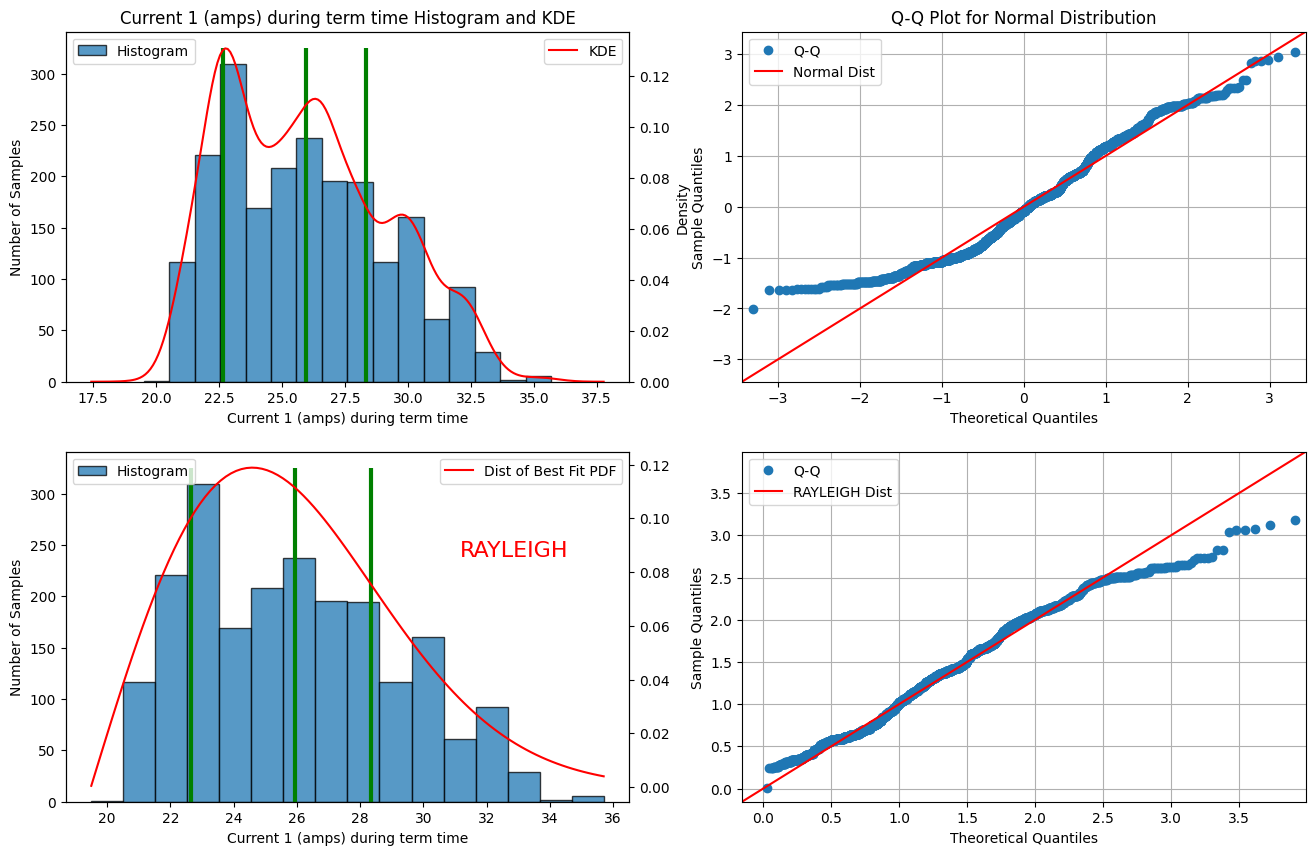

In [7]:
my.statistical_analysis(dl1_term_times[True], bins=16, header=HEADER+' during term time', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### Off-Term Time

-------------------------CURRENT 1 (AMPS) OFF TERM-------------------------
DATASET STATISTICS:
Mean: 26.396428571428572
Standard Deviation: 3.0982001852293375
Minimum Value: 20.2
25th Percentile: 24.1
Median: 26.1
75th Percentile: 28.8
Maximum: 34.5
Skewness: 0.13942694578298537
Kurtosis: -0.7001763772763239

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9836, p=6.444743209887579e-13
DAgostino and Pearsons Test: stat=92.0550, p=1.0245168414160558e-20
Kolmogorov-Smirnov Test: stat=0.06587847369675137, p=8.782780076530244e-07

FITTING TO OTHER DISTRIBUTIONS: 

Best fitting distribution: exponweib
Best p value: 0.0008306551918825468
Parameters for the best fit: (0.3414477480391712, 4.317630284660822, 20.14874914667655, 9.756461023676977)


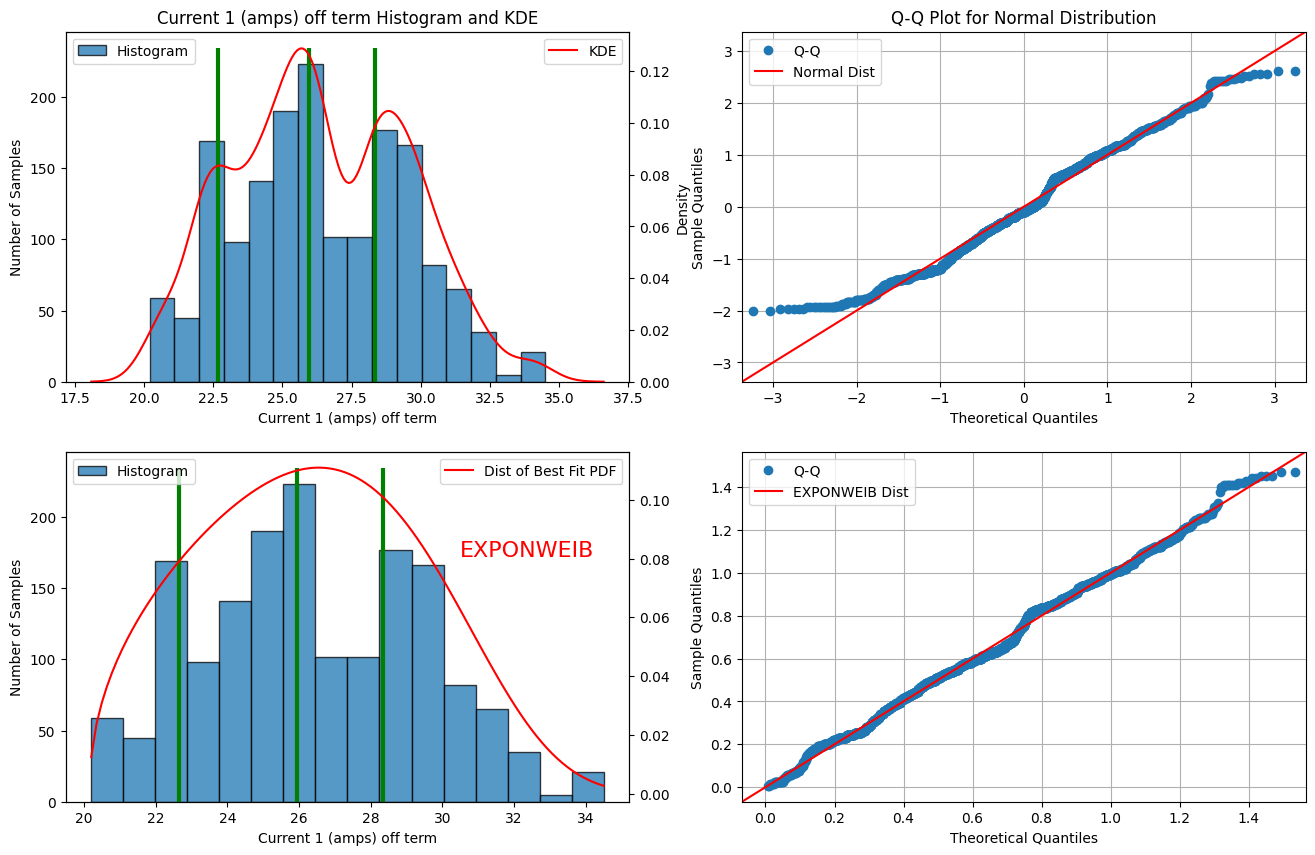

In [8]:
my.statistical_analysis(dl1_term_times[False], bins=16, header=HEADER+' off term', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### Weekends

------------------------CURRENT 1 (AMPS) ON WEEKENDS-----------------------
DATASET STATISTICS:
Mean: 25.795454545454547
Standard Deviation: 3.0368722355750517
Minimum Value: 20.7
25th Percentile: 23.1
Median: 25.5
75th Percentile: 28.3
Maximum: 33.4
Skewness: 0.2664293368014098
Kurtosis: -0.9965606123367401

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9591, p=1.285107639993929e-16
DAgostino and Pearsons Test: stat=234.5914, p=1.1458494369832116e-51
Kolmogorov-Smirnov Test: stat=0.08404341831590273, p=6.153743916995009e-07

FITTING TO OTHER DISTRIBUTIONS: 

Best fitting distribution: gamma
Best p value: 0.0002515252433293665
Parameters for the best fit: (3.6014283624547114, 19.607988634401377, 1.7180595567648718)


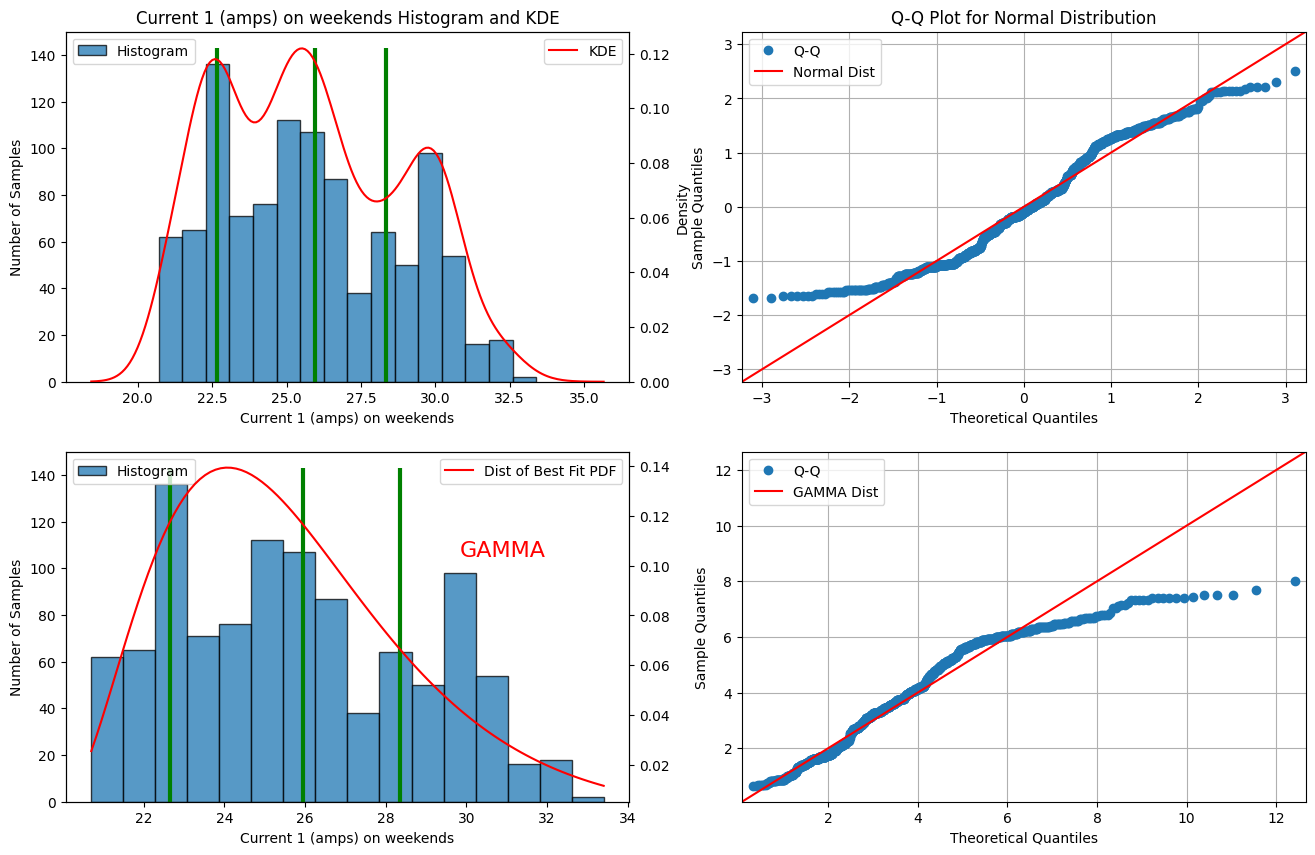

In [9]:
# call this again to make sure we have the same HEADER - time loss but oh well
daily_samples = dl1[HEADER].groupby(dl1["Date/Time"].dt.weekday).apply(list)

dl1_weekends = []
for i in (5, 6):
    dl1_weekends += daily_samples[i]
dl1_weekends = pd.Series(dl1_weekends)
my.statistical_analysis(dl1_weekends, bins=16, header=HEADER+' on weekends', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### Weekdays

------------------------CURRENT 1 (AMPS) ON WEEKDAYS-----------------------
DATASET STATISTICS:
Mean: 26.28657913931437
Standard Deviation: 3.200540510533312
Minimum Value: 19.5
25th Percentile: 23.6
Median: 26.2
75th Percentile: 28.6
Maximum: 35.7
Skewness: 0.2959327905612448
Kurtosis: -0.6930353874974955

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9780, p=3.44026456377672e-20
DAgostino and Pearsons Test: stat=176.6039, p=4.476693424142885e-39
Kolmogorov-Smirnov Test: stat=0.057520821680176526, p=2.506636283216106e-08

FITTING TO OTHER DISTRIBUTIONS: 

Best fitting distribution: exponweib
Best p value: 2.0984139436485163e-05
Parameters for the best fit: (0.6947162264205111, 2.8493254051511245, 19.475447044046483, 8.760311351546452)


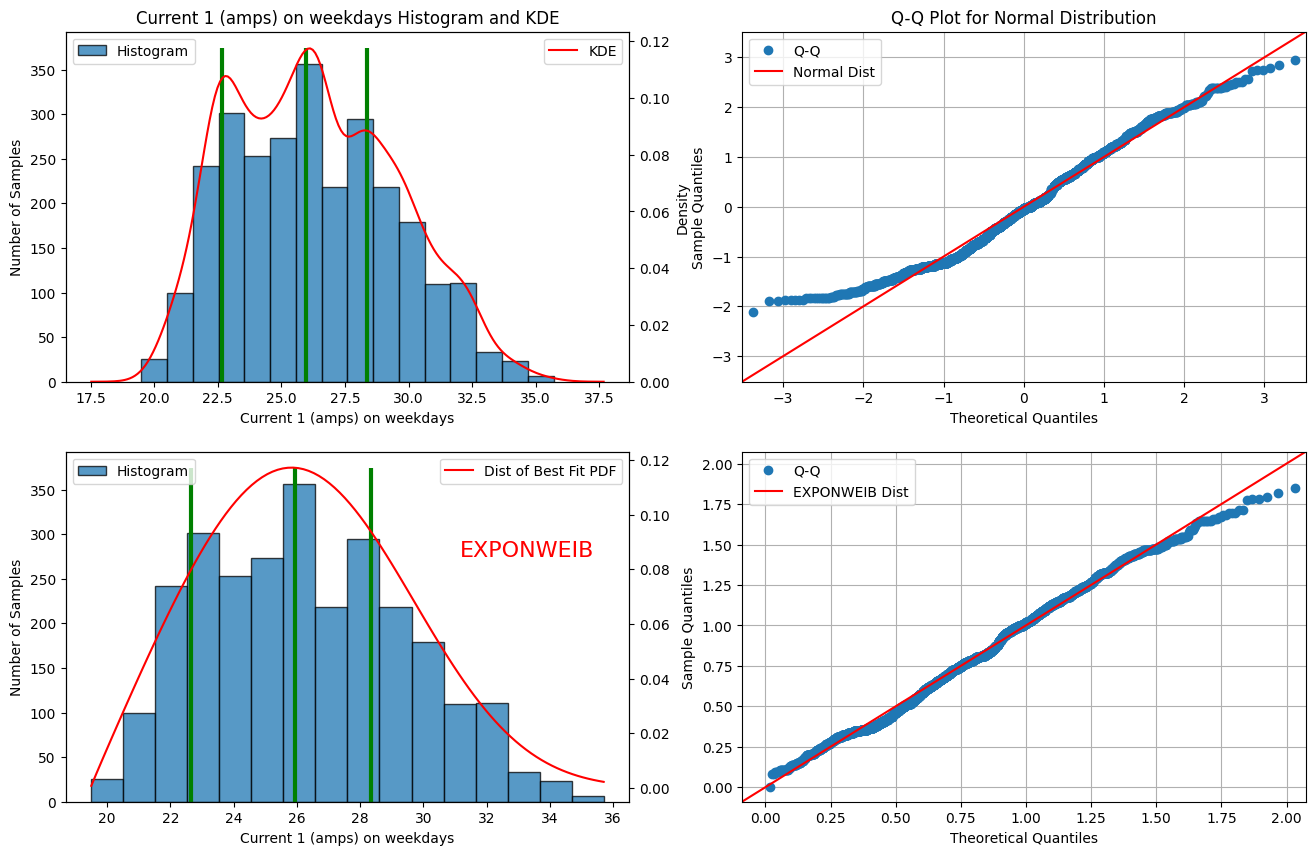

In [10]:
dl1_weekdays = []
for i in range(5):
    dl1_weekdays += daily_samples[i]
dl1_weekdays = pd.Series(dl1_weekdays)
my.statistical_analysis(dl1_weekdays, bins=16, header=HEADER+' on weekdays', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### Working Days

------------------CURRENT 1 (AMPS) ON WORKING DAYS (9-17)------------------
DATASET STATISTICS:
Mean: 26.094771241830067
Standard Deviation: 3.1452344734857953
Minimum Value: 19.5
25th Percentile: 23.3
Median: 26.1
75th Percentile: 28.6
Maximum: 35.7
Skewness: 0.359595868259303
Kurtosis: -0.6142662550694902

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9724, p=3.4815838404070002e-12
DAgostino and Pearsons Test: stat=49.4142, p=1.861382017509517e-11
Kolmogorov-Smirnov Test: stat=0.07445894875660261, p=7.150725307059522e-05

FITTING TO OTHER DISTRIBUTIONS: 

Best fitting distribution: rayleigh
Best p value: 0.0014303943804477336
Parameters for the best fit: (19.474818225613532, 5.182483855745131)


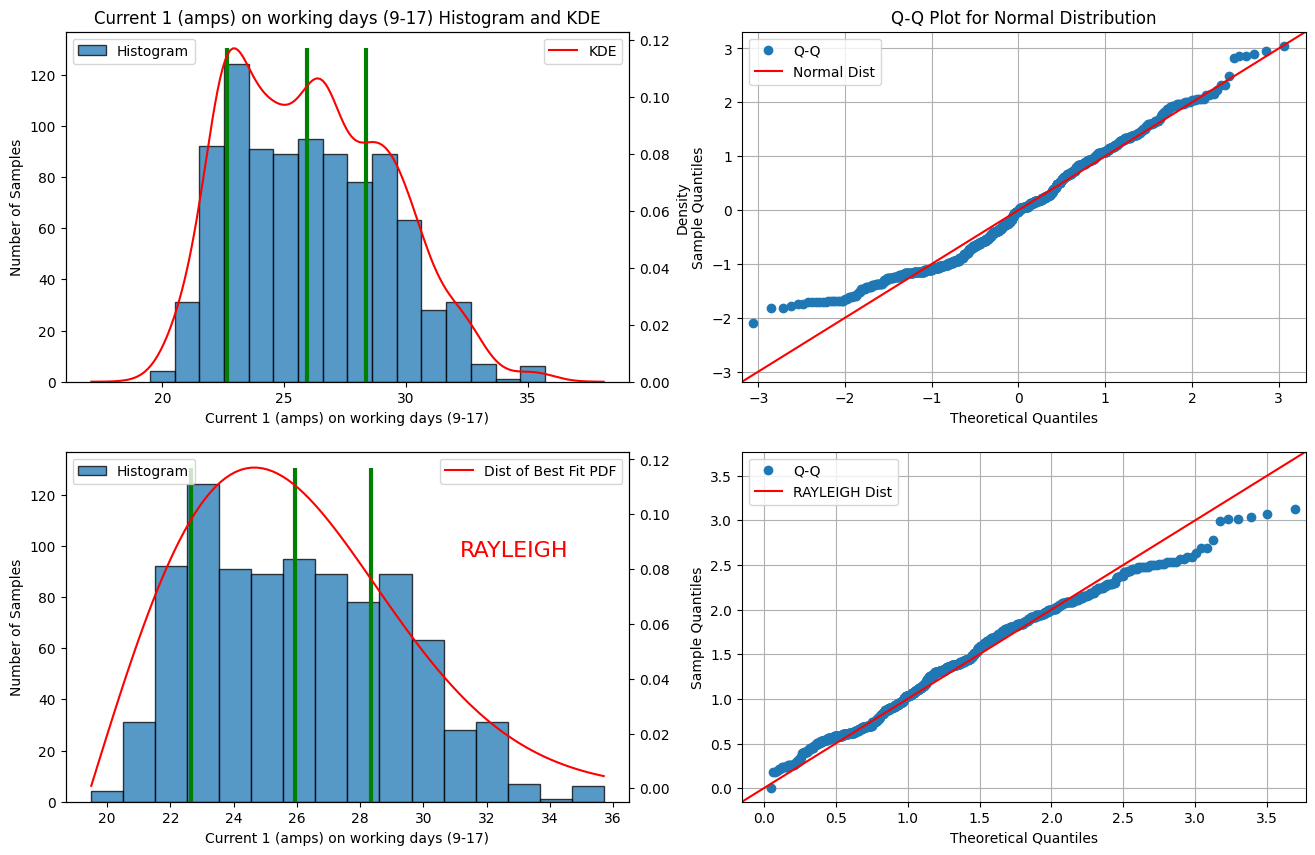

In [11]:
# WEEK DAYS, 9-17
daily_hourly_samples = dl1[HEADER].groupby([dl1["Date/Time"].dt.weekday, dl1["Date/Time"].dt.hour]).apply(list)

dl1_working_days = []
for i in range(5):
    for j in range(9, 17):
        dl1_working_days += daily_hourly_samples[i][j]
dl1_working_days = pd.Series(dl1_working_days)
my.statistical_analysis(dl1_working_days, bins=16, header=HEADER+' on working days (9-17)', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### Working Night

----------CURRENT 1 (AMPS) ON WORKING NIGHTS (0-9+17-24, WEEKDAYS)---------
DATASET STATISTICS:
Mean: 26.38311403508772
Standard Deviation: 3.2237026419690302
Minimum Value: 20.2
25th Percentile: 23.8
Median: 26.2
75th Percentile: 28.6
Maximum: 34.5
Skewness: 0.26302708406320136
Kurtosis: -0.7256397246419981

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9787, p=8.008304963030204e-16
DAgostino and Pearsons Test: stat=126.8964, p=2.7847735664773947e-28
Kolmogorov-Smirnov Test: stat=0.0556960684035811, p=2.330747520542022e-05

FITTING TO OTHER DISTRIBUTIONS: 

Best fitting distribution: weibull_min
Best p value: 0.001172824748727357
Parameters for the best fit: (2.2026434279144342, 19.688809736022755, 7.561077503491701)


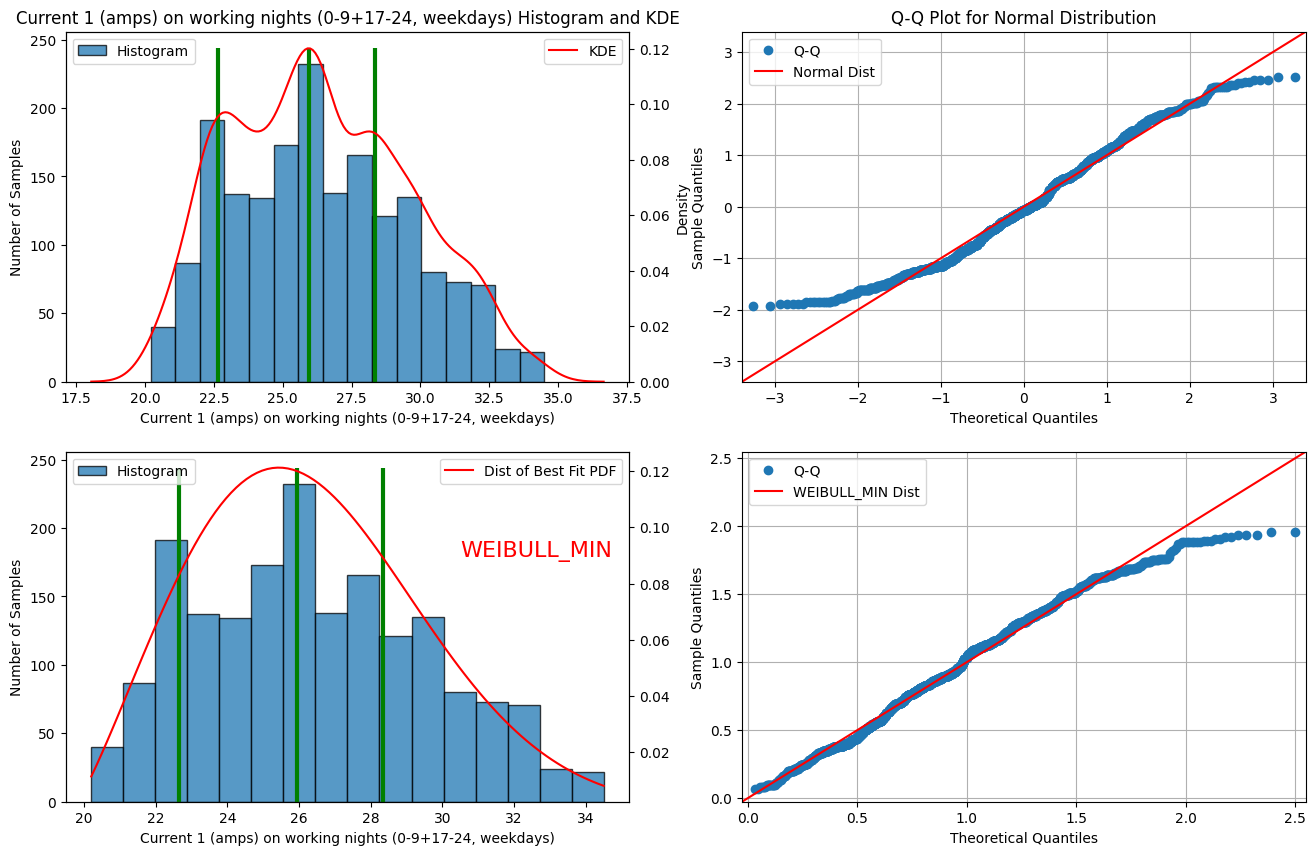

In [12]:
dl1_working_nights = []
for i in range(5):
    for j in list(range(0, 9))+list(range(17, 24)):
        dl1_working_nights += daily_hourly_samples[i][j]
dl1_working_nights = pd.Series(dl1_working_nights)
my.statistical_analysis(dl1_working_nights, bins=16, header=HEADER+' on working nights (0-9+17-24, weekdays)', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### Daily Average

-------------------CURRENT 1 (AMPS) DAILY MOVING AVERAGE-------------------
DATASET STATISTICS:
Mean: 26.15332066869301
Standard Deviation: 2.709099643085386
Minimum Value: 21.261702127659575
25th Percentile: 24.01273339122883
Median: 26.222340425531918
75th Percentile: 28.180612244897958
Maximum: 32.10425531914894
Skewness: 0.16000296875849143
Kurtosis: -0.8116572849503587

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9705, p=0.06064053797776044
DAgostino and Pearsons Test: stat=4.9618, p=0.08366872027739174
Kolmogorov-Smirnov Test: stat=0.08462356336309729, p=0.5858148259647495

FITTING TO OTHER DISTRIBUTIONS: 


c:\Users\ogahe\OneDrive\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis\Lib\site-packages\scipy\stats\_continuous_distns.py:2137: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +



Best fitting distribution: rayleigh
Best p value: 0.6442137914125255
Parameters for the best fit: (20.815263538211855, 4.2328521592683845)


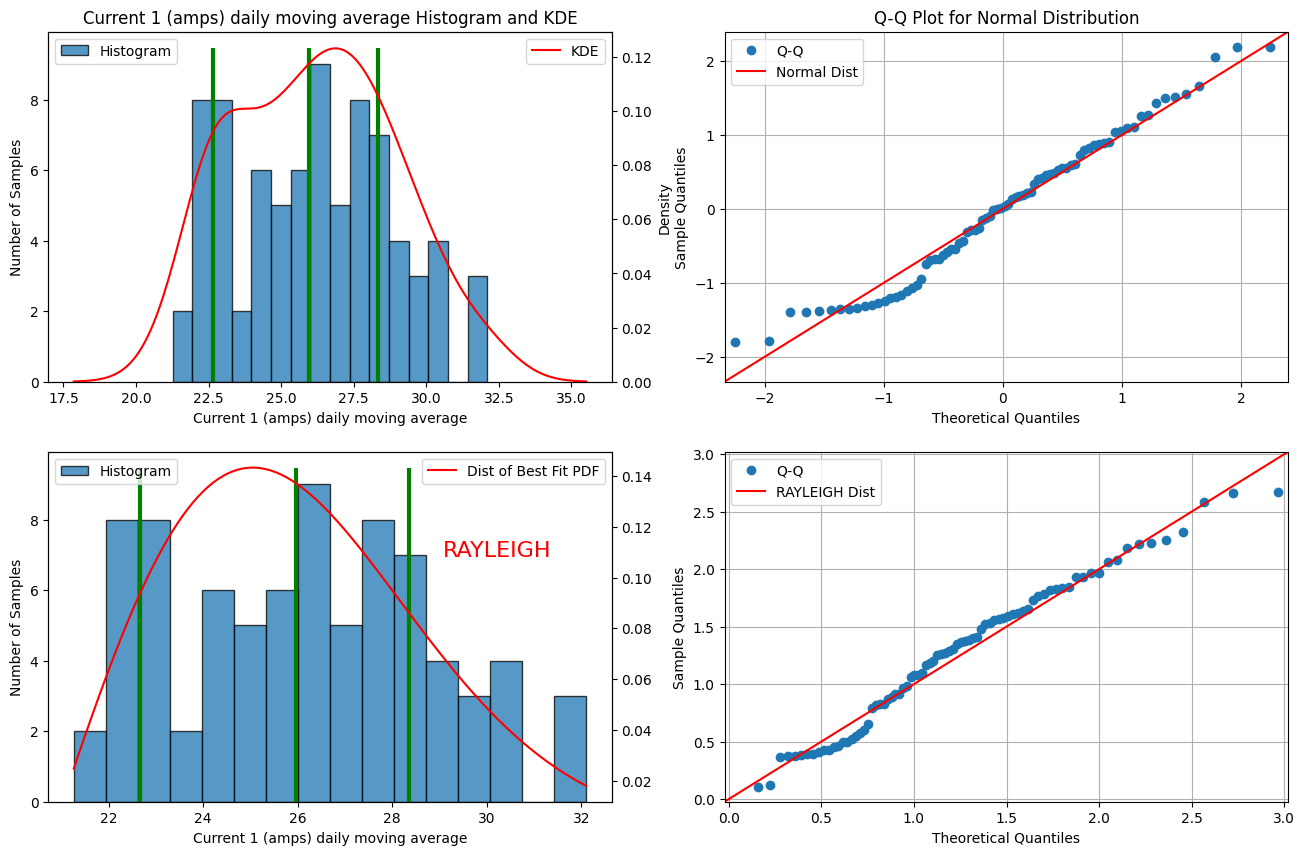

In [13]:
my.statistical_analysis(dl1[HEADER].groupby(dl1.index.round('1d')).mean(), bins=16, header=HEADER+' daily moving average', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions


### Weekly Average

----------------------CURRENT 1 (AMPS) WEEKLY AVERAGE----------------------
DATASET STATISTICS:
Mean: 26.138806510864658
Standard Deviation: 2.13018581465352
Minimum Value: 23.485671641791043
25th Percentile: 24.107343992205145
Median: 26.209439557180982
75th Percentile: 27.61991723446272
Maximum: 29.834421364985165
Skewness: 0.21212098328546966
Kurtosis: -1.3768774821144332

STATISTICAL TESTS FOR NORMALITY:
Shapiro Wilk Test: stat=0.9109, p=0.21887440143853487
DAgostino and Pearsons Test: stat=2.5716, p=0.2764328951522101
Kolmogorov-Smirnov Test: stat=0.20279442019124105, p=0.6365428846196535

FITTING TO OTHER DISTRIBUTIONS: 


c:\Users\ogahe\OneDrive\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
c:\Users\ogahe\OneDrive\Documents\!IMPERIAL\YEAR2\UROP2\power_analysis\Lib\site-packages\scipy\stats\_continuous_distns.py:2137: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +



Best fitting distribution: dweibull
Best p value: 0.9377265264134487
Parameters for the best fit: (2.380350148094279, 26.145756799350245, 2.190646823661199)


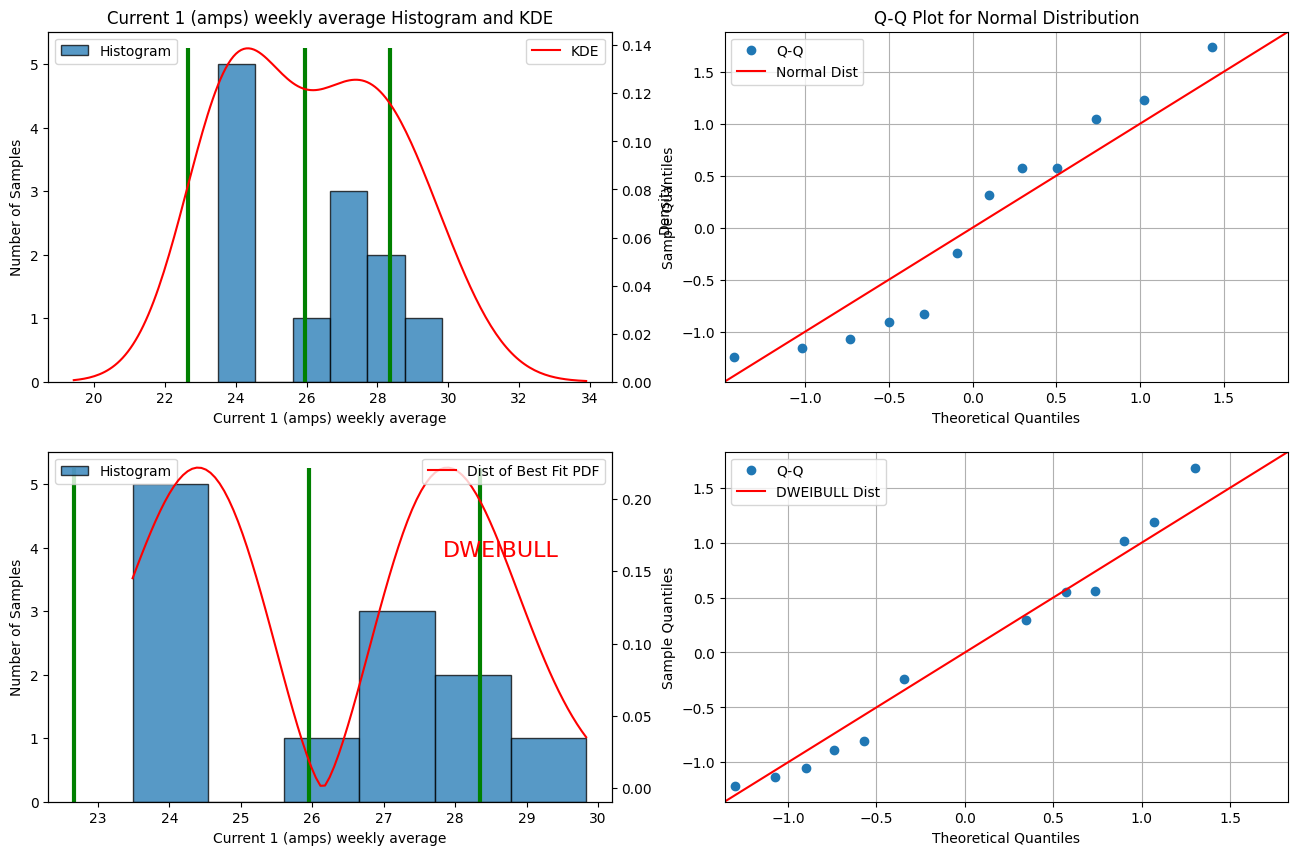

In [14]:
my.statistical_analysis(dl1[HEADER].groupby(dl1.index.round('7d')).mean(), bins=6, header=HEADER+' weekly average', modes=MODES, include_autocorr=INCLUDE_AUTOCORR, cdf=INCLUDE_CDF)

#### Conclusions

## Analysis in Frequency: Autocorrelation and PSD

### FFT
A possible idea could be to do an FFT: as we know the sample size is 30 mins, we can get an accurate reading of the frequency of the current, up to a precision of 1 hour<sup>-1</sup>.
From the [scipy documentation](https://docs.scipy.org/doc/scipy/tutorial/fft.html#d-discrete-fourier-transforms), it is interesting to use a BLACKMAN window in order to minimize spectral leakage and improve the quality of our FFT.

We can also identify and plot peaks to identify some areas of periodicity.

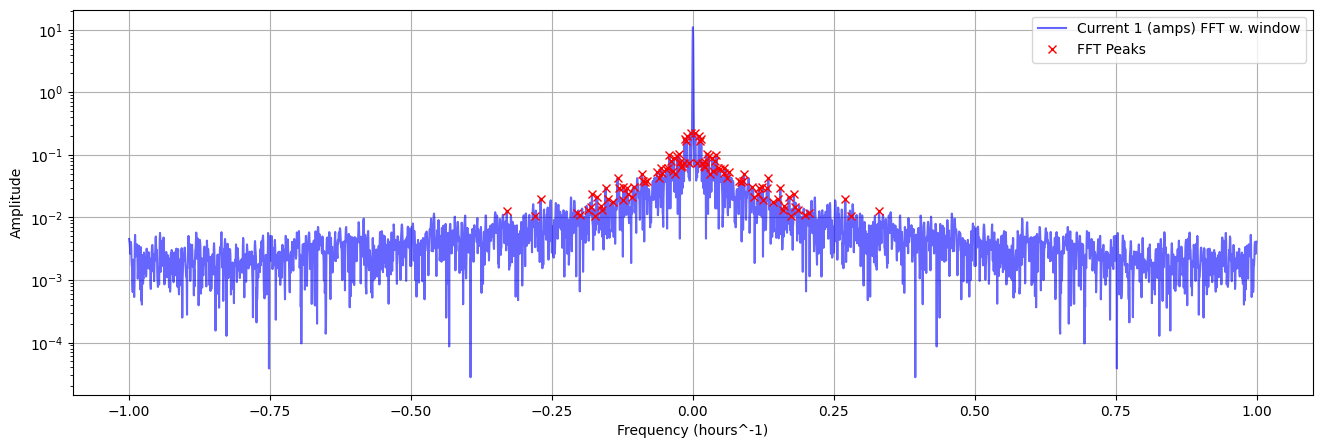

Amplitude at periodicity of 1h: 0.966518733771163
Amplitude at periodicity of 1d: 0.1061720197759175
Amplitude at periodicity of 7d: 0.1061720197759175
Amplitude at periodicity of 30d: 0.1061720197759175


In [15]:
# average time difference between each sample
T = np.mean([(dl1.index[i+1] - dl1.index[i]).seconds/3600 for i in range(len(dl1) - 1)]) 
N = len(dl1)

# obtain FFT using BLACKMAN window 
dl1_fft = fft.fft(np.array(dl1[HEADER])*sig.windows.blackman(len(dl1)))
dl1_freqs = fft.fftfreq(N, T)

# find peaks
fft_peaks, _ = sig.find_peaks(np.abs(dl1_fft), threshold=10)

plt.figure(figsize=FIGSIZE)
plt.plot(fft.fftshift(dl1_freqs), 1.0/N*np.abs(fft.fftshift(dl1_fft)), '-b', alpha=0.6, label=HEADER+' FFT w. window')
plt.plot(dl1_freqs[fft_peaks], 1.0/N*np.abs(dl1_fft)[fft_peaks], 'xr', label='FFT Peaks')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (hours^-1)')
plt.legend(loc='upper right')
plt.yscale('log')
plt.grid()
plt.show()

timeframes = ['1h', '1d', '7d', '30d']
for timeframe in timeframes:
    hour = my.Timedelta_to_hour(timeframe)
    freq = 1/hour
    amplitude_at_closest, idx = my.find_nearest(np.abs(dl1_fft), freq)
    print(f'Amplitude at periodicity of {timeframe}: {amplitude_at_closest}')

### Autocorrelation and PSD
It's important to remember this is a stochastic random process. As such, we can plot the autocorrelation function and its power spectral density (PSD), allowing us to make a more accurate statement on how power is distributed in each frequency. We will use SciPy's [Welch Approximation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html), as well as Pandas's [autocorr() method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html)

Autocorrelation for Lag 1: 0.9806196938381512
Maximum Autocorrelation (dB): 57.761443635712325
Times where a peak occurs: [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Peak Amplitudes: [57.761443635712325, 50.89706625428052, 46.0561816500221, 45.36283054192114, 44.589188474818265, 39.420106737309936, 36.174767892766695, 35.821218772532326, 34.604236657706586, 34.3748931188111, 33.70864281249999, 32.48297376383111, 32.79534663127931, 33.32424997959024, 31.119413203041155, 29.729463664968087, 29.53924730800544, 29.47344256009126, 28.35231821817715, 26.978555003860954, 27.12828083574642, 27.10268047522178, 25.573301767358195, 26.589631181324247, 26.20177092542474, 25.230498016472573, 25.4805206236994]


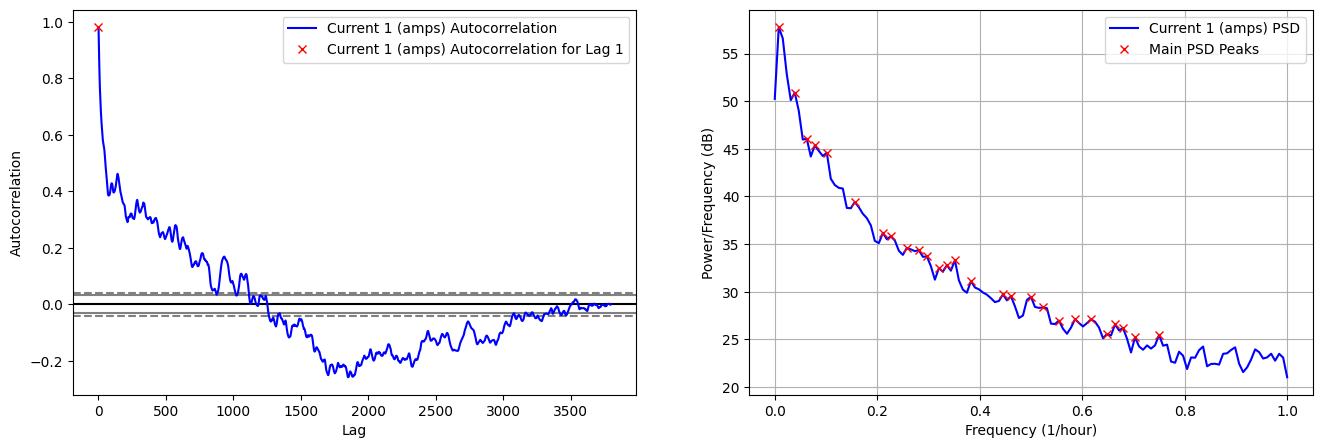

In [16]:
my.autocorr_and_psd_analysis(dl1[HEADER], header=HEADER, peaks_height=25)